In [1]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
os.environ["CUDA_VISIBLE_DEVICES"] = os.environ.get("VSCODE_PROXY_CUDA_DEVICE", "")
# os.environ["CUDA_VISIBLE_DEVICES"] = os.environ["VSCODE_PROXY_CUDA_DEVICE"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")

plt.rcParams['mathtext.fontset'] = 'cm'


Loading on device: cpu


In [2]:
# Define the base path where the model and data files are stored
base_path = '../src/saved_models/p_23_dmlp_512_ReLU_random_scale_0.1_decay_2.0_08180102' 

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 512, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

# Define the file names for the model and data files
model_file = 'final.pth'        # File containing the trained model
train_data_file = 'train_data.pth'  # File containing the training data
test_data_file = 'test_data.pth'   # File containing the test data

# Load the model and data on the specified device
# Note: The `weights_only=True` argument assumes a custom loader function or a modified PyTorch function. 
# It is not standard in PyTorch's `torch.load`. This should be clarified or corrected.
model_data = torch.load(
    os.path.join(base_path, model_file),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
print(f"Trained Model Dict: {model_data.keys()}\n")  # Print the keys of the loaded model dictionary

# Load the training and testing data
train_data = torch.load(
    os.path.join(base_path, train_data_file),  # Path to the training data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
test_data = torch.load(
    os.path.join(base_path, test_data_file),   # Path to the testing data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)

# Extract the model parameters from the loaded model dictionary
model_load = model_data["model"]  # Access the model section of the dictionary
for key in model_load.keys():
    # Print each model parameter's key and its shape in a formatted manner
    print(f"{key:<30} {str(model_load[key].shape):<25}")

Trained Model Dict: dict_keys(['model', 'train_loss', 'test_loss', 'train_losses', 'test_losses', 'grad_norms', 'param_norms', 'epoch', 'optimizer', 'scheduler'])

mlp.W_in                       torch.Size([512, 23])    
mlp.W_out                      torch.Size([23, 512])    
mlp.basis                      torch.Size([23, 23])     


In [3]:
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)]).to(device)
all_labels = torch.tensor([(i + j) % p for i, j in all_data]).to(device)
train_labels = torch.tensor([(i + j) % p for i, j in train_data]).to(device)

fourier_basis, fourier_basis_names = get_fourier_basis(p, device)
fourier_basis_unstd, _ = get_fourier_basis_unstd(p, device)

# Process Checking

In [4]:
all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

In [5]:
# Create a single list of all neuron‐records (dropping the model key)
all_neuron_records = []
sparse_level_ls =[]

for model in loaded_files.values():
    # Decode this model’s weights
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model, fourier_basis)
    d_mlp = W_in_decode.shape[0]
    sparse_level_ls.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)


    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi  = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        scale_diff = coeff_in_scale**2 - 2 * coeff_out_scale**2

        # Append just the neuron‐level info
        all_neuron_records.append({
            "neuron":     neuron,
            "frequency":  max_freq_ls[neuron],
            "scale_in":   coeff_in_scale,
            "phi_in":     coeff_in_phi,
            "scale_out":  coeff_out_scale,
            "phi_out":    coeff_out_phi,
            "scale_diff": scale_diff
        })

In [6]:
def plot_model(key):
    # Retrieve the model state dict using the selected key
    model_load = loaded_files[key]
    
    # Create the figure with two subplots
    plt.figure(figsize=(15, 10))
    
    # First subplot: Decoded W_in
    plt.subplot(1, 2, 1)
    # Compute data (example: W_in multiplied by the transpose of the fourier_basis)
    data_in = model_load['mlp.W_in'][:40] @ fourier_basis.T
    abs_max_in = np.abs(data_in).max()
    plt.imshow(data_in, cmap='RdBu', vmin=-abs_max_in, vmax=abs_max_in)
    plt.title('Decoded W_in')
    plt.colorbar(shrink=0.5)
    
    # Second subplot: Decoded W_out
    plt.subplot(1, 2, 2)
    # Compute data (example: transpose of W_out multiplied by the transpose of the fourier_basis)
    data_out = model_load['mlp.W_out'][:,:40].T @ fourier_basis.T
    abs_max_out = np.abs(data_out).max()
    plt.imshow(data_out, cmap='RdBu', vmin=-abs_max_out, vmax=abs_max_out)
    plt.title('Decoded W_out')
    plt.colorbar(shrink=0.5)

    plt.suptitle(f'Model Key: {key}')
    plt.show()

# Create a selection slider with the sorted keys from your loaded_files dictionary
key_options = sorted(loaded_files.keys())
interact(plot_model, key=widgets.SelectionSlider(options=key_options, description='Model Key'));

interactive(children=(SelectionSlider(description='Model Key', options=(0, 200, 400, 600, 800, 1000, 1200, 140…

In [7]:
def interactive_model(key):
    # Clear previous outputs so the new model's output is shown clearly
    clear_output(wait=True)
    
    # Retrieve the model using the selected key
    model_load = loaded_files[key]
    
    # Decode the weights from the selected model
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
    #sparse_level = (W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4)/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4)/2
    
    # Determine the number of neurons (assuming the first dimension of W_in_decode equals d_mlp)
    d_mlp = W_in_decode.shape[0]
    print(f"Loaded Model Key: {key} with {d_mlp} neurons.\n")
    
    # Loop through each neuron and print the computed details
    for neuron in range(20):
        coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        sparsity = (W_in_decode[neuron,:].norm(p=4)**4/W_in_decode[neuron,:].norm(p=2)**4).mean()/2 + (W_out_decode[neuron,:].norm(p=4)**4/W_out_decode[neuron,:].norm(p=2)**4).mean()/2
        print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, "
              f"Scale {coeff_in_scale:.4f},{coeff_out_scale:.4f}, "
              f"2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, "
              f"Phi(out) {coeff_out_phi:.2f}",
              f"Sparsity {sparsity:.2f}",
              f"Para Norm {model_load['mlp.W_in'].norm(p=2, dim=1)[neuron]+model_load['mlp.W_out'].T.norm(p=2, dim=1)[neuron]:.2f}")
              #f"Scale Diff {coeff_in_scale**2-2*coeff_out_scale**2:.8f}")

    print(f"Para Norm All {model_load['mlp.W_in'].norm(p=2):.2f}")
# Create an interactive widget for model selection using the keys in loaded_files.
model_keys = sorted(loaded_files.keys())
interact(interactive_model, key=widgets.SelectionSlider(options=model_keys, description='Model Key'));

interactive(children=(SelectionSlider(description='Model Key', options=(0, 200, 400, 600, 800, 1000, 1200, 140…

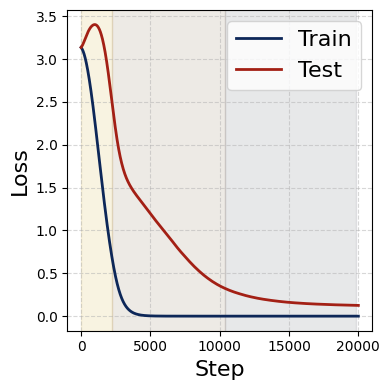

In [8]:
# Define stage boundaries
stage_1_end = 2200
stage_2_end = 10400
epochs = sorted(loaded_files.keys())
plot_epochs = epochs[:-150]

# Plot training and test losses with academic publication style
fig, ax = plt.subplots(figsize=(4, 4))

# Plot with specified colors
ax.plot(model_data["train_losses"][:20000], color='#0D2758', linewidth=2, label='Train')
ax.plot(model_data["test_losses"][:20000], color='#A32015', linewidth=2, label='Test')

ax.axvspan(0, stage_1_end, alpha=0.15, color='#D4AF37')
ax.axvspan(stage_1_end, stage_2_end, alpha=0.15, color='#8B7355')
ax.axvspan(stage_2_end, plot_epochs[-1], alpha=0.15, color='#60656F')

# Set labels with larger font
ax.set_xlabel('Step', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)

# Improve legend
ax.legend(fontsize=16, loc="upper right")

# Set grid
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../figures/grokk_loss.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

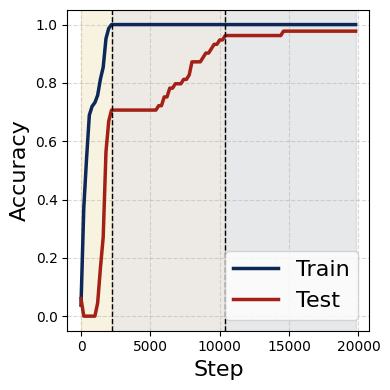

In [9]:
train_accs = []
test_accs = []
for key in sorted(loaded_files.keys()):
    model = EmbedMLP(
        d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp,
        act_type=act_type, use_cache=False
    ).to(device)
    model.load_state_dict(loaded_files[key])
    model.eval()
    with torch.no_grad():
        train_logits = model(train_data)
        train_acc = acc_rate(train_logits, train_labels)
        train_accs.append(train_acc)

        test_logits = model(test_data)
        test_labels = torch.tensor([(i + j) % p for i, j in test_data]).to(device)
        test_acc = acc_rate(test_logits, test_labels)
        test_accs.append(test_acc)

# --- Plot the results ---
plot_train_accs = train_accs[:-150]
plot_test_accs = test_accs[:-150]

fig, ax = plt.subplots(figsize=(4, 4))

# Add shaded regions for the three stages
ax.axvspan(0, stage_1_end, alpha=0.15, color='#D4AF37')
ax.axvspan(stage_1_end, stage_2_end, alpha=0.15, color='#8B7355')
ax.axvspan(stage_2_end, plot_epochs[-1], alpha=0.15, color='#60656F')

# Plot the accuracy lines
ax.plot(plot_epochs, plot_train_accs, label='Train', color='#0D2758', linewidth=2.5)
ax.plot(plot_epochs, plot_test_accs, label='Test', color='#A32015', linewidth=2.5)

# Add vertical lines to separate stages
ax.axvline(x=stage_1_end, color='black', linestyle='--', linewidth=1)
ax.axvline(x=stage_2_end, color='black', linestyle='--', linewidth=1)

# Final plot styling
ax.set_xlabel('Step', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16, loc="lower right")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../figures/grokk_acc.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()



In [10]:
# Calculate phase difference averaged over all neurons
epochs = sorted(loaded_files.keys())
abs_phase_diff = []
sparse_level = []

for epoch in epochs:
    model_load = loaded_files[epoch]
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
    
    # Calculate phase differences for all neurons at this epoch
    phase_diffs = []
    
    sparse_level.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)
    
    # Process each neuron
    for neuron in range(W_in_decode.shape[0]):  # Process first 20 neurons
        coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        
        # Calculate phase difference
        phase_diff = normalize_to_pi(coeff_out_phi - 2 * coeff_in_phi)
        phase_diffs.append(phase_diff)
    
    
    # Average across neurons
    phase_diffs = np.array(phase_diffs)
    abs_phase_diff.append(np.mean(np.abs(np.sin(phase_diffs))))

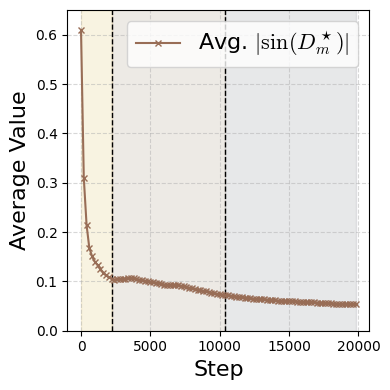

In [11]:
# X-axis (epochs)
x = np.array(epochs[:100])

# Define stage boundaries (same as accuracy plot)
stage_1 = 2200
stage_2 = 10400

# Create single plot with single axis
fig, ax = plt.subplots(figsize=(4, 4))

# Add shaded regions for the three stages
ax.axvspan(0, stage_1, alpha=0.15, color='#D4AF37')  # Gold - Stage 1
ax.axvspan(stage_1, min(stage_2, x[-1]), alpha=0.15, color='#8B7355')  # Bronze/Tan - Stage 2
ax.axvspan(stage_2, x[-1], alpha=0.15, color='#60656F')  # Silver - Stage 3

# Add vertical lines to separate stages
ax.axvline(x=stage_1_end, color='black', linestyle='--', linewidth=1)
ax.axvline(x=stage_2_end, color='black', linestyle='--', linewidth=1)

# Plot average sine and cosine on same axis
ax.plot(x, abs_phase_diff[:100], marker='x', markersize=5, color='#986d56', 
        label=r"Avg. $|\sin(D_m^\star)|$", linewidth=1.5)

# Set labels and title
ax.set_xlabel('Step', fontsize=16)
ax.set_ylabel('Average Value', fontsize=16)

# Set y-axis limits
ax.set_ylim([0, 0.65])

# Add legend
ax.legend(fontsize=16, loc="upper right")

# Add grid
ax.grid(True, alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig('../figures/grokk_abs_phase_diff.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

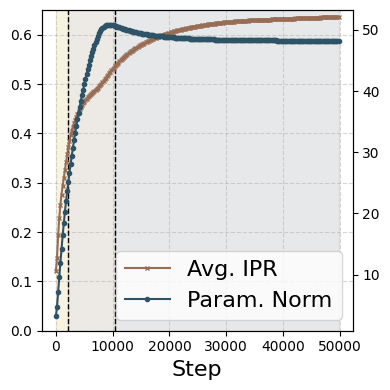

In [12]:
# X-axis (epochs)
x = np.array(epochs)

# Define stage boundaries (same as accuracy plot)
stage_1 = 2200
stage_2 = 10400

# Create single plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(4, 4))

# Add shaded regions for the three stages
ax1.axvspan(0, stage_1, alpha=0.15, color='#D4AF37')  # Gold - Stage 1
ax1.axvspan(stage_1, min(stage_2, x[-1]), alpha=0.15, color='#8B7355')  # Bronze/Tan - Stage 2
ax1.axvspan(stage_2, x[-1], alpha=0.15, color='#60656F')  # Silver - Stage 3

# Add vertical lines to separate stages
ax1.axvline(x=stage_1_end, color='black', linestyle='--', linewidth=1)
ax1.axvline(x=stage_2_end, color='black', linestyle='--', linewidth=1)

# Plot average IPR on first y-axis
line1 = ax1.plot(x, sparse_level, marker='x', markersize=3, color='#986d56',
                label=r"Avg. IPR", linewidth=1.5)

# Set labels for first axis
ax1.set_xlabel('Step', fontsize=16)
ax1.tick_params(axis='y')
ax1.set_ylim([0, 0.65])

# Create second y-axis for param norms
ax2 = ax1.twinx()
line2 = ax2.plot(x, model_data['param_norms'][::200], marker='o', markersize=3, color='#2E5266',
                label=r"Param. Norm", linewidth=1.5)

# Set label for second axis
ax2.tick_params(axis='y')

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, fontsize=16, loc="lower right")

# Add grid
ax1.grid(True, alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig('../figures/grokk_avg_ipr.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

Logits shape: torch.Size([529, 23])


/tmp/ipykernel_3093828/968748031.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


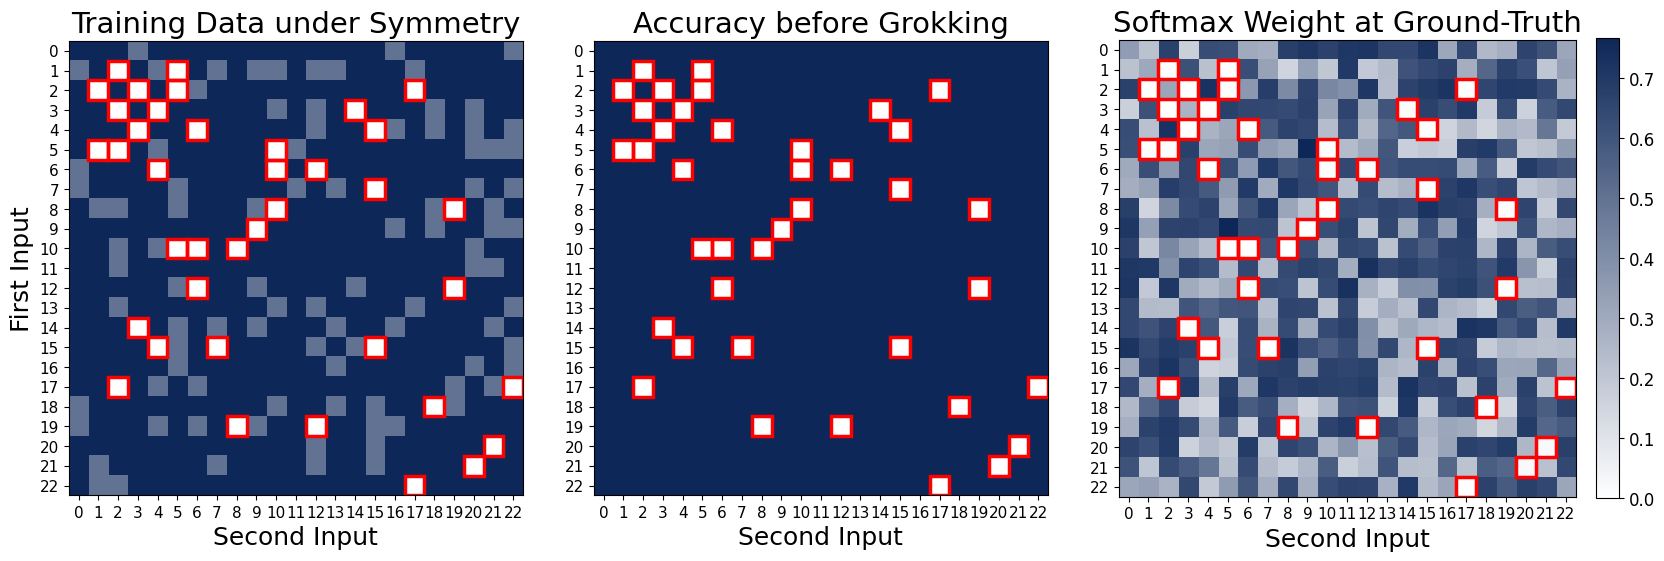

In [20]:
# Load model at step 2200 and create 3-plot comparison
torch.set_default_dtype(torch.float32)

# Load model at step 2200
model_data_2200 = torch.load(
    os.path.join(base_path, "2200.pth"),   # Path to the model file at step 2200
    weights_only=True,                    # Load weights only
    map_location=device                   # Specify the device to load the model onto
)
model_load_2200 = model_data_2200["model"]

# Create and load the model
model = EmbedMLP(
    d_vocab=d_vocab,
    d_model=d_model,
    d_mlp=d_mlp,
    act_type=act_type,
    use_cache=False
)
model.to(device)
model.load_state_dict(model_load_2200)

# Set up caching if needed
all_cache = {}
model.remove_all_hooks()
model.cache_all(all_cache)
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)], dtype=torch.long).to(device)

logits = model(all_data).squeeze(1)
print(f"Logits shape: {logits.size()}")

# Create custom colormap
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['white', '#0D2758'],
    N=256
)

# Create figure with GridSpec for better control
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1.1], wspace=0.15)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Plot 1: Training data mask (1 for training data, 0.5 for transpose in training, 0 for others)
train_mask = torch.zeros(p, p)
# Create a set of training data for quick lookup
train_set = set([(int(i), int(j)) for i, j in train_data])

# Track which points are truly test data (neither in training nor symmetric)
true_test_points = []

for i in range(p):
    for j in range(p):
        if (i, j) in train_set:
            train_mask[i, j] = 1.0
        elif (j, i) in train_set:
            train_mask[i, j] = 0.65
        else:
            train_mask[i, j] = 0.0
            true_test_points.append((i, j))

im1 = ax1.imshow(train_mask.cpu().numpy(), cmap=cividis_with_white, vmin=0, vmax=1, aspect='equal')
ax1.set_title('Training Data under Symmetry', fontsize=21)
ax1.set_ylabel('First Input', fontsize=18)
ax1.set_xlabel('Second Input', fontsize=18)

# Set ticks and labels
x_locs = np.arange(p)
y_locs = np.arange(p)
ax1.set_xticks(x_locs)
ax1.set_yticks(y_locs)
ax1.set_xticklabels(x_locs, fontsize=11)
ax1.set_yticklabels(y_locs, fontsize=11)

# Add red frames for true test points in plot 1
for i, j in true_test_points:
    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2.5, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)

# Plot 2: Prediction accuracy (1 where model predicts correctly, 0 otherwise)
predicted_outputs = torch.argmax(logits, dim=1).view(p, p)
ground_truth_grid = all_labels.view(p, p)
accuracy_mask = (predicted_outputs == ground_truth_grid).float()

im2 = ax2.imshow(accuracy_mask.cpu().numpy(), cmap=cividis_with_white, vmin=0, vmax=1, aspect='equal')
ax2.set_title('Accuracy before Grokking', fontsize=21)
ax2.set_xlabel('Second Input', fontsize=18)

ax2.set_xticks(x_locs)
ax2.set_yticks(y_locs)
ax2.set_xticklabels(x_locs, fontsize=11)
ax2.set_yticklabels(y_locs, fontsize=11)

# Add red frames for true test points in plot 2
for i, j in true_test_points:
    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2.5, edgecolor='red', facecolor='none')
    ax2.add_patch(rect)

# Plot 3: Softmax probability at ground truth position
# Apply softmax to logits
probs = torch.softmax(logits, dim=1)

# Get probability at ground truth position for each input
ground_truth_probs = torch.zeros(p * p, device=device)
for idx, (i, j) in enumerate(all_data):
    correct_answer = (i + j) % p
    ground_truth_probs[idx] = probs[idx, correct_answer]

ground_truth_probs_grid = ground_truth_probs.view(p, p)

# Use the actual max value from the data for vmax
prob_max = ground_truth_probs_grid.max().item()
im3 = ax3.imshow(ground_truth_probs_grid.cpu().detach().numpy(), cmap=cividis_with_white, vmin=0, vmax=prob_max, aspect='equal')
ax3.set_title('Softmax Weight at Ground-Truth', fontsize=21)
ax3.set_xlabel('Second Input', fontsize=18)

ax3.set_xticks(x_locs)
ax3.set_yticks(y_locs)
ax3.set_xticklabels(x_locs, fontsize=11)
ax3.set_yticklabels(y_locs, fontsize=11)

# Add red frames for true test points in plot 3
for i, j in true_test_points:
    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2.5, edgecolor='red', facecolor='none')
    ax3.add_patch(rect)

# Add colorbar for plot 3
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('../figures/grokk_memorization_accuracy.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
total_pairs = p * p
train_pairs = len(train_data)
test_pairs = total_pairs - train_pairs
correct_predictions = accuracy_mask.sum().item()

Logits shape: torch.Size([529, 23])


/tmp/ipykernel_3093828/3610285484.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


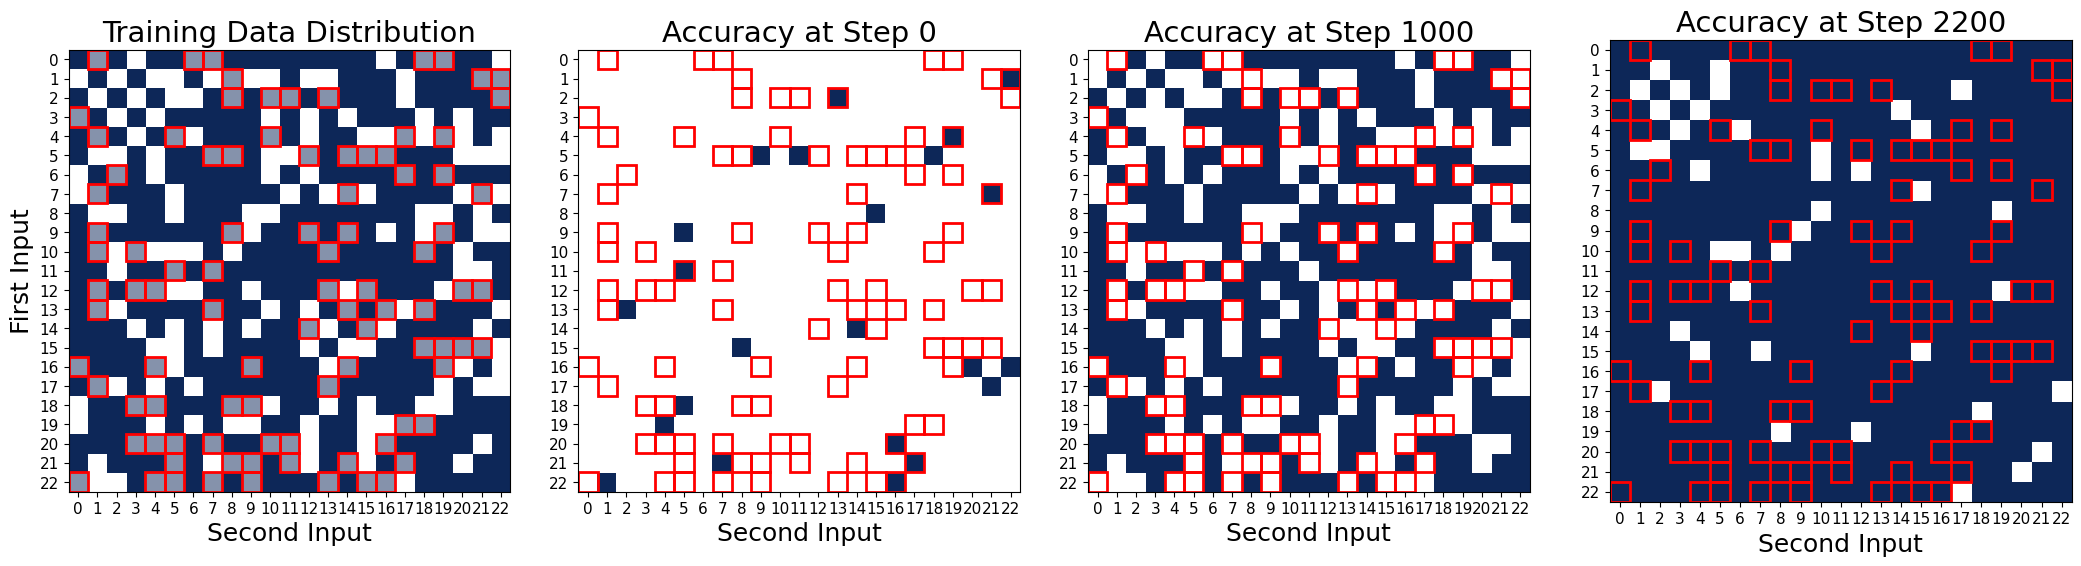

In [21]:
# Load models at steps 0, 1200, and 2200 and create 4-plot comparison
torch.set_default_dtype(torch.float32)

# Load model at step 0
model_data_0 = torch.load(
    os.path.join(base_path, "0.pth"),
    weights_only=True,
    map_location=device
)
model_load_0 = model_data_0["model"]

# Create and load the model at step 0
model_0 = EmbedMLP(
    d_vocab=d_vocab,
    d_model=d_model,
    d_mlp=d_mlp,
    act_type=act_type,
    use_cache=False
)
model_0.to(device)
model_0.load_state_dict(model_load_0)

# Get predictions for step 0
all_cache = {}
model_0.remove_all_hooks()
model_0.cache_all(all_cache)
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)], dtype=torch.long).to(device)
logits_0 = model_0(all_data).squeeze(1)

# Load model at step 1200
model_data_1200 = torch.load(
    os.path.join(base_path, "1000.pth"),
    weights_only=True,
    map_location=device
)
model_load_1200 = model_data_1200["model"]

# Create and load the model at step 1200
model_1200 = EmbedMLP(
    d_vocab=d_vocab,
    d_model=d_model,
    d_mlp=d_mlp,
    act_type=act_type,
    use_cache=False
)
model_1200.to(device)
model_1200.load_state_dict(model_load_1200)

# Get predictions for step 1200
all_cache = {}
model_1200.remove_all_hooks()
model_1200.cache_all(all_cache)
logits_1200 = model_1200(all_data).squeeze(1)

# Load model at step 2200
model_data_2200 = torch.load(
    os.path.join(base_path, "2200.pth"),
    weights_only=True,
    map_location=device
)
model_load_2200 = model_data_2200["model"]

# Create and load the model at step 2200
model_2200 = EmbedMLP(
    d_vocab=d_vocab,
    d_model=d_model,
    d_mlp=d_mlp,
    act_type=act_type,
    use_cache=False
)
model_2200.to(device)
model_2200.load_state_dict(model_load_2200)

# Get predictions for step 2200
all_cache = {}
model_2200.remove_all_hooks()
model_2200.cache_all(all_cache)
logits_2200 = model_2200(all_data).squeeze(1)

print(f"Logits shape: {logits_0.size()}")

# Create custom colormap
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['white', '#0D2758'],
    N=256
)

# Create figure with GridSpec for better control - now with 4 subplots
fig = plt.figure(figsize=(26, 6))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1.1], wspace=0.15)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# Create a set of training data for quick lookup
train_set = set([(int(i), int(j)) for i, j in train_data])

# Track which training points don't have their symmetric counterpart in training
asymmetric_train_points = []

# Plot 1: Training data distribution
train_mask = torch.zeros(p, p)
for i in range(p):
    for j in range(p):
        if (i, j) in train_set and (j, i) in train_set:
            train_mask[i, j] = 1.0
        elif (i, j) in train_set and (j, i) not in train_set:
            train_mask[i, j] = 0.5
            asymmetric_train_points.append((i, j))
        else:
            train_mask[i, j] = 0.0

im1 = ax1.imshow(train_mask.cpu().numpy(), cmap=cividis_with_white, vmin=0, vmax=1, aspect='equal')
ax1.set_title('Training Data Distribution', fontsize=21)
ax1.set_ylabel('First Input', fontsize=18)
ax1.set_xlabel('Second Input', fontsize=18)

# Set ticks and labels
x_locs = np.arange(p)
y_locs = np.arange(p)
ax1.set_xticks(x_locs)
ax1.set_yticks(y_locs)
ax1.set_xticklabels(x_locs, fontsize=11)
ax1.set_yticklabels(y_locs, fontsize=11)

# Add frames for asymmetric training points (training points without symmetric counterpart)
for i, j in asymmetric_train_points:
    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2.0, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)

# Plot 2: Prediction accuracy at step 0
predicted_outputs_0 = torch.argmax(logits_0, dim=1).view(p, p)
ground_truth_grid = all_labels.view(p, p)
accuracy_mask_0 = (predicted_outputs_0 == ground_truth_grid).float()

im2 = ax2.imshow(accuracy_mask_0.cpu().numpy(), cmap=cividis_with_white, vmin=0, vmax=1, aspect='equal')
ax2.set_title('Accuracy at Step 0', fontsize=21)
ax2.set_xlabel('Second Input', fontsize=18)

ax2.set_xticks(x_locs)
ax2.set_yticks(y_locs)
ax2.set_xticklabels(x_locs, fontsize=11)
ax2.set_yticklabels(y_locs, fontsize=11)

# Add frames for asymmetric training points
for i, j in asymmetric_train_points:
    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2.0, edgecolor='red', facecolor='none')
    ax2.add_patch(rect)

# Plot 3: Prediction accuracy at step 1200
predicted_outputs_1200 = torch.argmax(logits_1200, dim=1).view(p, p)
accuracy_mask_1200 = (predicted_outputs_1200 == ground_truth_grid).float()

im3 = ax3.imshow(accuracy_mask_1200.cpu().numpy(), cmap=cividis_with_white, vmin=0, vmax=1, aspect='equal')
ax3.set_title('Accuracy at Step 1000', fontsize=21)
ax3.set_xlabel('Second Input', fontsize=18)

ax3.set_xticks(x_locs)
ax3.set_yticks(y_locs)
ax3.set_xticklabels(x_locs, fontsize=11)
ax3.set_yticklabels(y_locs, fontsize=11)

# Add frames for asymmetric training points
for i, j in asymmetric_train_points:
    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2.0, edgecolor='red', facecolor='none')
    ax3.add_patch(rect)

# Plot 4: Prediction accuracy at step 2200
predicted_outputs_2200 = torch.argmax(logits_2200, dim=1).view(p, p)
accuracy_mask_2200 = (predicted_outputs_2200 == ground_truth_grid).float()

im4 = ax4.imshow(accuracy_mask_2200.cpu().numpy(), cmap=cividis_with_white, vmin=0, vmax=1, aspect='equal')
ax4.set_title('Accuracy at Step 2200', fontsize=21)
ax4.set_xlabel('Second Input', fontsize=18)

ax4.set_xticks(x_locs)
ax4.set_yticks(y_locs)
ax4.set_xticklabels(x_locs, fontsize=11)
ax4.set_yticklabels(y_locs, fontsize=11)

# Add frames for asymmetric training points
for i, j in asymmetric_train_points:
    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2.0, edgecolor='red', facecolor='none')
    ax4.add_patch(rect)

plt.tight_layout()
plt.savefig('../figures/grokk_memorization_accuracy_common_to_rare.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

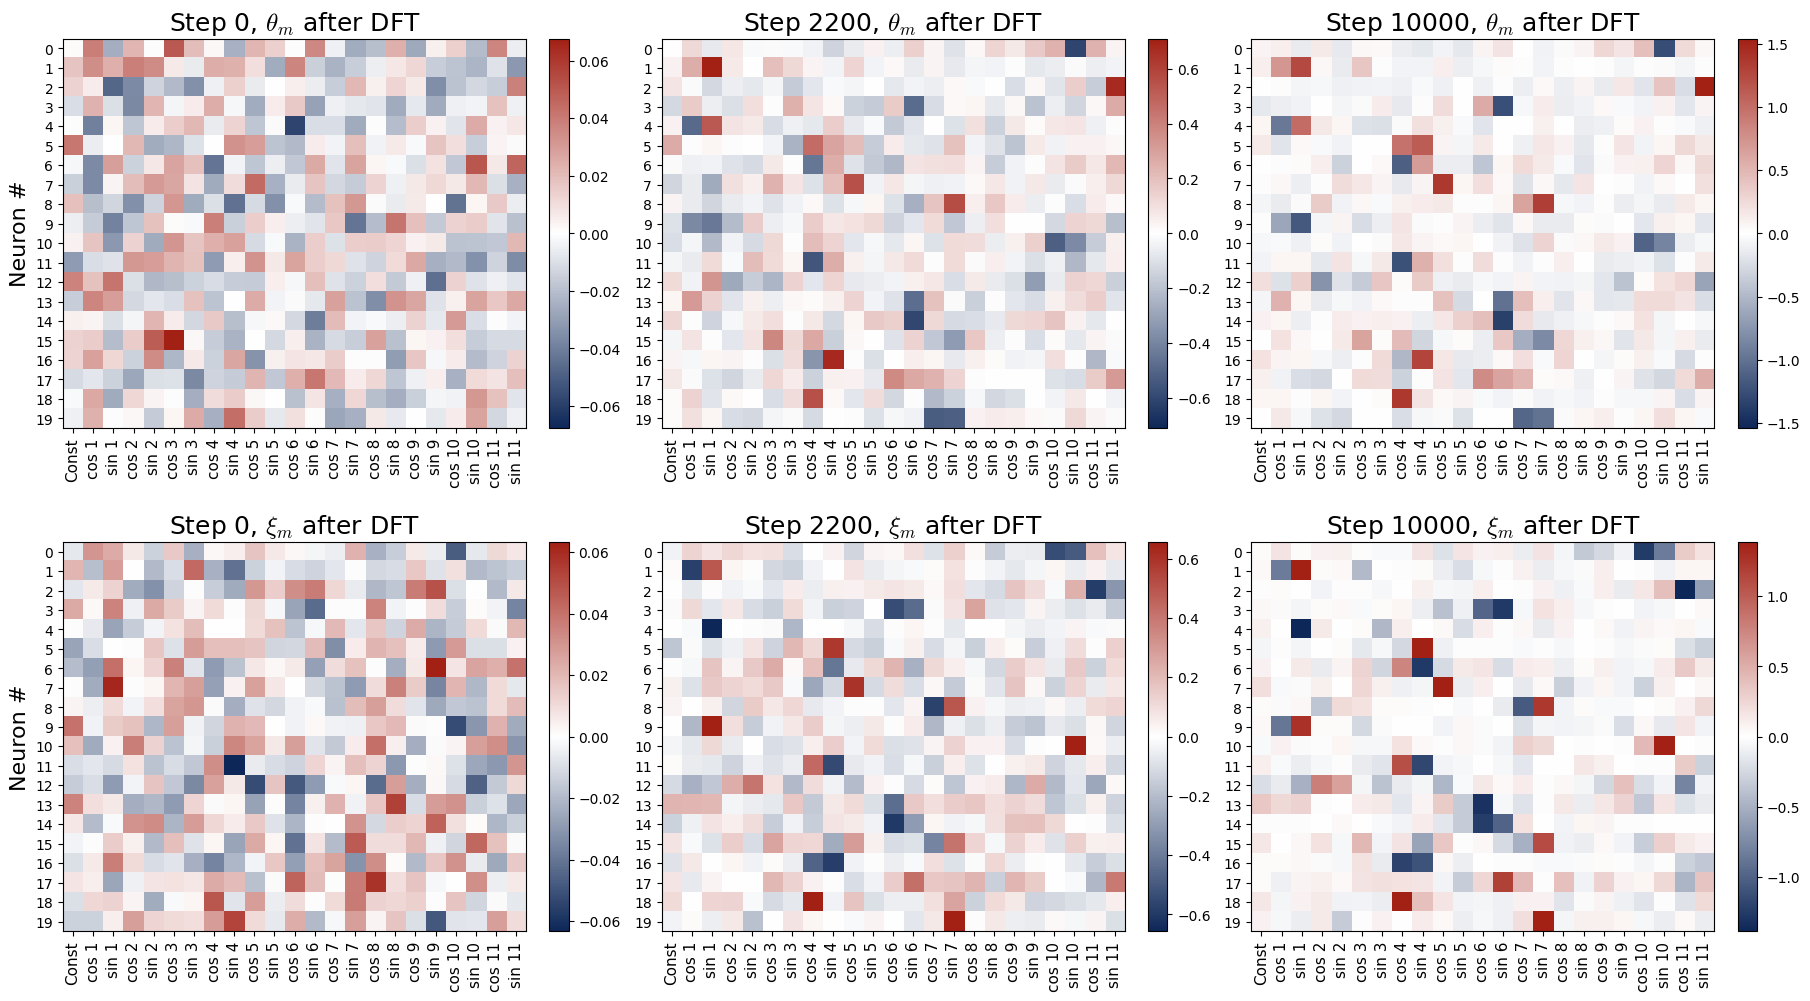

In [15]:
# Create a custom colormap that centers 'cividis' with white at zero
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['#0D2758', 'white', '#A32015'],  # Colors at low, middle, and high points in 'cividis'
    N=256
)

def plot_decoded_weights(
    loaded_files,
    fourier_basis,
    fourier_basis_names,
    keys,
    num_components=20
):
    """
    Plots decoded W_in and W_out for each key in `keys`.

    Parameters
    ----------
    loaded_files : list of dict
        Each element is a dict containing 'mlp.W_in' and 'mlp.W_out'.
    fourier_basis : np.ndarray
        Your Fourier basis matrix of shape (p, p).
    fourier_basis_names : list of str
        Names/labels for each Fourier mode (length p).
    keys : list of int
        Indices into loaded_files to plot.
    num_components : int, optional
        How many top components (rows) to show, by default 20.
    """
    n = len(keys)
    fig, axes = plt.subplots(2, n, figsize=(18, 3.3 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)
    #fig, axes = plt.subplots(2, n, figsize=(12, 4 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)

    # Ensure axes is always 2×n
    if n == 1:
        axes = axes.reshape(2, 1)

    x_locs = np.arange(len(fourier_basis_names))
    y_locs = np.arange(num_components)

    for col, key in enumerate(keys):
        W_in = loaded_files[key]['mlp.W_in']
        W_out = loaded_files[key]['mlp.W_out']

        # --- Decoded W_in on row 0, col `col`
        data_in = (W_in @ fourier_basis.T)[:num_components]
        abs_max_in = np.abs(data_in).max()
        ax_in = axes[0, col]
        im_in = ax_in.imshow(
            data_in,
            cmap=cividis_with_white,
            vmin=-abs_max_in,
            vmax= abs_max_in,
            aspect='auto'
        )
        ax_in.set_title(rf'Step {key}, $\theta_m$ after DFT', fontsize=18)
        ax_in.set_xticks(x_locs)
        ax_in.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_in.set_yticks(y_locs)
        ax_in.set_yticklabels(y_locs)
        if key == 0: ax_in.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_in, ax=ax_in)

        # --- Decoded W_out on row 1, col `col`
        data_out = (W_out.T @ fourier_basis.T)[:num_components]
        abs_max_out = np.abs(data_out).max() * 0.85
        ax_out = axes[1, col]
        im_out = ax_out.imshow(
            data_out,
            cmap=cividis_with_white,
            vmin=-abs_max_out,
            vmax= abs_max_out,
            aspect='auto'
        )
        ax_out.set_title(rf'Step {key}, $\xi_m$ after DFT', fontsize=18)
        ax_out.set_xticks(x_locs)
        ax_out.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_out.set_yticks(y_locs)
        ax_out.set_yticklabels(y_locs)
        if key == 0: ax_out.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_out, ax=ax_out)

    plt.savefig('../figures/grokk_decoded_weights_dynamic.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage:
keys = [0, 2200, 10000]  # whatever subset of loaded_files you want
plot_decoded_weights(loaded_files, fourier_basis, fourier_basis_names, keys, num_components=20)